#### Subtle variations of https://github.com/zdebeurs/rv_net/blob/main/2_3_1_HARPS_Linear_FC_CNN_June10_2023.ipynb osing only ConvNN

In [1]:
# import needed packages
import os.path
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.size'] = 15

import pandas as pd
from astropy.stats import median_absolute_deviation
import numpy as np
from tqdm.notebook import tqdm
from tqdm.notebook import trange

# calculation of scatter removed
from astropy.stats import median_absolute_deviation

2023-12-08 14:15:53.835643: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/isidro/anaconda3/envs/rv_net_debeurs/lib/python3.9/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/isidro/anaconda3/envs/rv_net_debeurs/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take d

In [2]:
# methods from exoplanet_ml
from ops import training
from tf_util import config_util
from tf_util import configdict
from tf_util import estimator_runner

In [3]:
from rv_net import data_HARPS_N
from rv_net import  data, rv_model, estimator_util, load_dataset_ridge, ridge_regress_harps

In [4]:
# Read in files for cross-validation
eval_method ='cross_val' #"val"# "val"#"cross_val" # "val" # "test"
ccf_len = 46
DATA_DIR = 'Archive_HARPS_N_NEW DRS/TF_records_Nov2021/' #TF_record_July_10_21_no_planets_median_prov_rvs/' #HARPS-N Solar Telescope Data (using old DRS)/' #TF_record_July_10_21_no_planets_same_test_set' #TF_record_July_10_21_no_planets_v2'

if eval_method =="cross_val":
    data_files = tf.data.Dataset.list_files(DATA_DIR+'*cross_val*',shuffle=False)
    data_files = [t.numpy() for t in data_files]
    TRAIN_FILE_NAME_LIST = []
    VAL_FILE_NAME_LIST = []

    N = len(data_files)
    for i in range(N):
        val_files = [data_files[i]]
        #print(val_files)
        VAL_FILE_NAME_LIST.append(val_files)
        train_files = data_files[0:i] + data_files[i+1:]
        TRAIN_FILE_NAME_LIST.append(train_files)
        # add all the training files

    NUM_TRAINING_EXAMPLES = 503
    NUM_VALIDATION_EXAMPLES = 51

elif eval_method =="val":
    TRAIN_FILE_NAME_LIST = [[os.path.join(DATA_DIR, "TF_ccf_full_train")]]
    VAL_FILE_NAME_LIST = [[os.path.join(DATA_DIR, "TF_ccf_val")]]#test")]]

    NUM_TRAINING_EXAMPLES = 503
    NUM_VALIDATION_EXAMPLES = 61
elif eval_method =="test":
    TRAIN_FILE_NAME_LIST = [[os.path.join(DATA_DIR, "TF_ccf_full_train")]]
    VAL_FILE_NAME_LIST = [[os.path.join(DATA_DIR, "TF_ccf_test")]]#test")]]

    NUM_TRAINING_EXAMPLES = 503
    NUM_VALIDATION_EXAMPLES = 61
else:
    print("Please select a valid evaluation method: 'cross_val' or 'val' or 'test'")

2023-12-08 14:15:55.546574: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 14:15:55.548269: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
# @title Data loader
def _example_parser(serialized_example):
    """Parses a single tf.Example into feature and label tensors."""
    feature_name = "Rescaled CCF_residuals_cutoff"#"Rescaled CCF_residuals" #CCF_residuals
    label_name = "activity signal"#"RV",
    label2_name = "BJD"
    data_fields = {
        feature_name: tf.io.FixedLenFeature([ccf_len], tf.float32), #[161], tf.float32),
        label_name: tf.io.FixedLenFeature([], tf.float32),
        label2_name: tf.io.FixedLenFeature([], tf.float32),
    }
    parsed_fields = tf.io.parse_single_example(serialized_example, features=data_fields)
    return parsed_fields[feature_name], parsed_fields[label_name]*1000, parsed_fields[label2_name]

In [6]:
def load_dataset(filenames, batch_size, mode=tf.estimator.ModeKeys.EVAL):
    filename_dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = filename_dataset.flat_map(tf.data.TFRecordDataset)
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=NUM_TRAINING_EXAMPLES)
    dataset = dataset.map(_example_parser, num_parallel_calls=4)
    dataset = dataset.batch(batch_size)
    return dataset

Secondly, Conv net

In [7]:

class CNNModel(tf.keras.Model):
    """A TensorFlow linear regression model."""

    def __init__(self, hparams):
        """Basic setup.

        Args:
          hparams: A ConfigDict of hyperparameters for building the model.

        Raises:
          ValueError: If mode is invalid.
        """
        super(CNNModel, self).__init__()
        self.hparams = hparams
        self.conv_layers = [
          tf.keras.layers.Conv1D(
              filters=hparams.num_conv_filters, 
              kernel_size=hparams.conv_kernel_size,
              activation=tf.keras.activations.relu,
              padding="same")
          for i in range(hparams.num_conv_layers)
        ]
        self.dense_layers = [
          tf.keras.layers.Dense(
              hparams.num_dense_units,
              activation=tf.keras.activations.relu)
          for i in range(hparams.num_dense_layers)
        ]
        self.output_layer = tf.keras.layers.Dense(1)
        
    def call(self, features, training=False):
        net = tf.expand_dims(features, -1)
        for conv in self.conv_layers:
            net = conv(net)
        batch_size, length, depth = net.shape
        net = tf.reshape(net, [batch_size, length*depth])
        for dense in self.dense_layers:
            net = dense(net)
        net = self.output_layer(net)
        return tf.squeeze(net)

In [8]:
def make_predictions(model, dataset):
    all_preds = []
    all_labels = []
    all_bjds = []
    for features, labels, bjds in dataset:
        preds = model(features, training=False)
        all_preds.append(preds.numpy())
        all_labels.append(labels.numpy())
        all_bjds.append(bjds.numpy())
    return np.concatenate(all_labels), np.concatenate(all_preds), np.concatenate(all_bjds)

In [9]:
def train(model, hparams, plots, model_name, num_epochs):#=100):
    train_dataset = load_dataset([TRAIN_FILE_NAME], batch_size=hparams.batch_size, mode=tf.estimator.ModeKeys.TRAIN)
    val_dataset = load_dataset([VAL_FILE_NAME], batch_size=min(1024, NUM_VALIDATION_EXAMPLES), mode=tf.estimator.ModeKeys.EVAL)
    loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
    Opt = tfa.optimizers.extend_with_decoupled_weight_decay(tf.optimizers.SGD)
    optimizer = Opt(weight_decay=hparams.weight_decay, learning_rate=hparams.learning_rate, momentum=hparams.momentum)
    metrics = [
             tf.keras.metrics.MeanSquaredError("train_loss"),
             tf.keras.metrics.RootMeanSquaredError("train_rmse")
    ]
    weight_decay_list_t.append(hparams.weight_decay)
    gaussian_noise_list_t.append(hparams.gaussian_noise_scale)

    metric_values = []
    for epoch in range(1, num_epochs+1):
        # Reset metric values for each new epoch.
        for m in metrics:
            m.reset_states()

        # Train over all batches in the training set.
        for features, labels, bjds in train_dataset:
            if hparams.gaussian_noise_scale:
                features += tf.random.normal(features.shape, stddev=hparams.gaussian_noise_scale)
                #print(hparams.gaussian_noise_scale)
            # One training step.
            with tf.GradientTape() as t:
                preds = model(features, training=True)
                loss = loss_fn(labels, preds)
            grads = t.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # Update the metrics.
            for m in metrics:
                m(labels, preds)
    
        # End of an epoch.
        epoch_metrics = {"epoch": epoch}
        # First, log the training metrics.
        for m in metrics:
            epoch_metrics[m.name] = m.result().numpy()
        # Next, evaluate over the validation set.
        labels_val, preds_val, bjd_val = make_predictions(model, val_dataset)
        epoch_metrics["val_rmse"] = np.sqrt(np.mean(np.square(preds_val - labels_val)))
        # Add a metric for the raw scatter started with
        epoch_metrics["original_rmse"] = np.std(labels_val)
        # Add a metric for raw scatter - corrected scatter
        epoch_metrics["difference_rmse"] = np.std(labels_val) - np.sqrt(np.mean(np.square(preds_val - labels_val)))
        # Log metrics to tensorboard.
        for metric, value in epoch_metrics.items():
            tf.summary.scalar(metric, value, step=epoch)
        epoch_metrics["epoch"] = epoch
        # Print metric values at selected epochs.
        if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
            print("{epoch}: Train loss: {train_loss:.4}, Train RMSE: {train_rmse:.4}, Val RMSE: {val_rmse:.4}".format(**epoch_metrics))
        metric_values.append(epoch_metrics)

    # Gather predictions
    labels, preds, bjd = make_predictions(model, train_dataset)
    labels_val, preds_val, bjd_val = make_predictions(model, val_dataset)
    all_bjds_val.append(bjd_val)
    bjd_run_val.append(bjd_val)
    all_pred_val.append(preds_val)
    pred_run_val.append(preds_val)
    all_labels_val.append(labels_val)
    labels_run_val.append(labels_val)

    # Scatter reduction plot
    sd_x = np.std(labels_val, ddof=1)
    rms_x = np.sqrt(np.mean(np.square(labels_val - preds_val)))
    rms_x_list.append(rms_x)
    rms_avg_list.append(rms_x)
    stel_removed = np.sqrt(np.abs(sd_x**2-rms_x**2))
    x_range = np.linspace(-4,5.5, 17)
    upper_bound = x_range+rms_x
    lower_bound = x_range-rms_x

    if plots=="ON":
        fig, axes = plt.subplots(1, 2, figsize=(24, 6))
        ax = axes[0]
        ax.plot([m["train_rmse"] for m in metric_values], label="Train RMSE")
        ax.plot([m["val_rmse"] for m in metric_values], label="Validation RMSE")
        ax.set_xlabel("Epoch")
        ax.legend(loc="upper right")

        # Gather predictions to plot against labels.
        ax = axes[1]
        ax.plot(preds, labels, ".", label="Training")
        ax.plot(preds_val, labels_val, ".", label="Validation")
        ax.set_xlabel("Actual Y")
        ax.set_ylabel("Predicted Y")
        ax.legend(loc="lower right")

        # plot the scatter reduction plot
        fig, ax1 = plt.subplots(figsize=(10, 6))
        ax1.plot(labels_val, preds_val, ".")
        ax1.plot(x_range,x_range, color="blue", label="1:1 ratio")
        #ax.plot(x_range,z[0]*x_range+z[1], color="blue")
        rms_fill=rms_x#0.15
        ax1.fill_between(x_range, x_range+rms_fill, x_range-rms_fill, facecolor='lightblue',
                    alpha=0.5, label="1 standard deviation")
        ax1.set_xlim(-4, 4);
        ax1.set_ylim(-4, 4);
        ax1.set_xlabel("HARPS-N Stellar Activity Signal (m/s)", size =16)
        ax1.set_ylabel("Model Predicted Stellar Activity Signal (m/s)", size =16)
        ax1.set_title(model_name+" Model Predictions of Stellar Activity signal(m/s)") #, %d epochs, weight decay: %.2e, gauss noise: %.2e " %(num_epochs, 
        #hparams.weight_decay, hparams.gaussian_noise_scale, size=16)
        textstr = '\n'.join((
            r'Raw scatter=%.3f m/s' % (sd_x, ),
            r'Corrected scatter=%.3f m/s' % (rms_x, ),
            r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
        ax1.text(-3.8, 3.5, textstr, size=15,
            ha="left", va="top",
            bbox=dict(boxstyle="square",
                      ec=(1., 0.5, 0.5),
                      fc=(1., 0.8, 0.8),
                      ))
        ax1.legend(loc="lower right")
    else:
        textstr = '\n'.join((
            r'Raw scatter=%.3f m/s' % (sd_x, ),
            r'Corrected scatter=%.3f m/s' % (rms_x, ),
            r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
        print(textstr)
    
    return metric_values


In [10]:
# CNN Model run

# Cross validation CNN Model Run (10 times)
rms_avg_list = []
weight_decay_list_t = []
gaussian_noise_list_t = []
rms_x_list = []

all_bjds_val = []
all_pred_val = []
all_labels_val = []
all_mean_val_preds = []
all_mean_val_bjds = []
all_mean_val_labels = []
all_mean_val_bjds = []

for index in range(0, len(VAL_FILE_NAME_LIST)):
    TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
    VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]
    bjd_run_val = []
    pred_run_val = []
    labels_run_val = []
    for k in range(0,2):#0): #should be 10 for a full run
        hparams = configdict.ConfigDict(dict(
            num_features=49,
            learning_rate=0.0085099,#0.0050618, #1e-3,
            momentum=0.9,
            batch_size=300,
            conv_kernel_size=3,
            num_conv_filters=16, #32,
            num_conv_layers=2,#4,
            num_dense_units=100,#500,
            num_dense_layers=1,
            weight_decay=0.0017600,#0.0012341, #5e-4, #7e-2,
            gaussian_noise_scale=0,#1.5,
        ))
        model = CNNModel(hparams)
        train(model, hparams, plots="OFF",model_name="CNN", num_epochs=90)#35)#65)
        print(model)
        print("________________________")
        print("Cross-val number: "+str(index+1)+", Run number: "+str(k+1))
    mean_val_preds = np.mean(pred_run_val, axis=0)
    mean_val_labels = np.mean(labels_run_val, axis=0)
    mean_val_bjds = np.mean(bjd_run_val, axis=0)
    all_mean_val_preds.append(mean_val_preds.tolist())
    all_mean_val_labels.append(mean_val_labels.tolist())
    all_mean_val_bjds.append(mean_val_bjds.tolist())


1: Train loss: 3.372, Train RMSE: 1.846, Val RMSE: 1.431
10: Train loss: 1.494, Train RMSE: 1.22, Val RMSE: 1.155
20: Train loss: 1.114, Train RMSE: 1.04, Val RMSE: 1.195
30: Train loss: 0.8173, Train RMSE: 0.9173, Val RMSE: 1.156
40: Train loss: 0.7585, Train RMSE: 0.8129, Val RMSE: 1.111
50: Train loss: 0.5364, Train RMSE: 0.7227, Val RMSE: 1.139
60: Train loss: 0.3702, Train RMSE: 0.6234, Val RMSE: 1.214
70: Train loss: 0.3155, Train RMSE: 0.5727, Val RMSE: 1.282
80: Train loss: 0.254, Train RMSE: 0.5169, Val RMSE: 1.299
90: Train loss: 0.2399, Train RMSE: 0.4864, Val RMSE: 1.341
Raw scatter=1.590 m/s
Corrected scatter=1.341 m/s
Stellar Error Removed=0.855 m/s
________________________
Cross-val number: 1, Run number: 1
1: Train loss: 3.762, Train RMSE: 1.864, Val RMSE: 1.54
10: Train loss: 1.362, Train RMSE: 1.207, Val RMSE: 1.268
20: Train loss: 0.9796, Train RMSE: 1.071, Val RMSE: 1.156
30: Train loss: 0.9384, Train RMSE: 0.9587, Val RMSE: 1.189
40: Train loss: 0.6669, Train RMSE:

80: Train loss: 0.3418, Train RMSE: 0.5855, Val RMSE: 1.113
90: Train loss: 0.3346, Train RMSE: 0.5434, Val RMSE: 1.08
Raw scatter=1.954 m/s
Corrected scatter=1.080 m/s
Stellar Error Removed=1.628 m/s
________________________
Cross-val number: 6, Run number: 1
1: Train loss: 3.37, Train RMSE: 1.822, Val RMSE: 1.851
10: Train loss: 1.457, Train RMSE: 1.181, Val RMSE: 1.353
20: Train loss: 1.121, Train RMSE: 1.059, Val RMSE: 1.279
30: Train loss: 0.9167, Train RMSE: 0.9728, Val RMSE: 1.24
40: Train loss: 0.7824, Train RMSE: 0.8945, Val RMSE: 1.183
50: Train loss: 0.7398, Train RMSE: 0.8327, Val RMSE: 1.173
60: Train loss: 0.6569, Train RMSE: 0.8639, Val RMSE: 1.168
70: Train loss: 0.445, Train RMSE: 0.663, Val RMSE: 1.145
80: Train loss: 0.3795, Train RMSE: 0.6636, Val RMSE: 1.204
90: Train loss: 0.3571, Train RMSE: 0.5598, Val RMSE: 1.146
Raw scatter=1.954 m/s
Corrected scatter=1.146 m/s
Stellar Error Removed=1.582 m/s
________________________
Cross-val number: 6, Run number: 2
1: Train

In [11]:
avg = np.mean(rms_avg_list)
print("________________________")
print(avg)

#flatten the lists
all_mean_val_preds = [item for sublist in all_mean_val_preds for item in sublist]
all_mean_val_labels = [item for sublist in all_mean_val_labels for item in sublist]
all_mean_val_bjds = [item for sublist in all_mean_val_bjds for item in sublist]

________________________
1.1545974


In [12]:
df = pd.DataFrame(list(zip(all_mean_val_labels,all_mean_val_preds, all_mean_val_bjds)), 
               columns =['labels', 'preds', 'BJD']) 
df_sorted = df.sort_values(by=['BJD'])
#df_sorted.to_excel('gdrive/Shared drives/Exoplanet_RV/cross_val_preds/val_preds_CNN_06_30_2021.xlsx', index = False)

# calculation of scatter removed
from astropy.stats import median_absolute_deviation

#df_sorted = df_from_excel
labels_68_percent_by_2 = (np.percentile(df_sorted["labels"], 84)-np.percentile(df_sorted["labels"], 16))/2
labels_median_absolute_deviation_norm = median_absolute_deviation(df_sorted["labels"])*1.4826
preds_68_percent_by_2 = (np.percentile(df_sorted["preds"], 84)-np.percentile(df_sorted["preds"], 16))/2

corrected_rvs = df_sorted["labels"]-df_sorted["preds"]
corrected_rvs_68_percent_by_2 = (np.percentile(corrected_rvs, 84)-np.percentile(corrected_rvs, 16))/2
corrected_rvs_median_absolute_deviation_norm = median_absolute_deviation(corrected_rvs)*1.4826

sd_labels = np.std(df_sorted["labels"], ddof=1)
sd_corrected_rv = np.std(corrected_rvs, ddof=1)
rms_x = np.sqrt(np.mean(np.square(df_sorted["labels"] - df_sorted["preds"])))


print("labels: sd: "+str(sd_labels))
print("corrected rv: sd: "+str(sd_corrected_rv))
print("____________________________________________")
print("labels: MAD*1.4826: "+str(labels_median_absolute_deviation_norm))
print("corrected rv: MAD*1.4826: "+str(corrected_rvs_median_absolute_deviation_norm))
print("____________________________________________")
print("labels: 68 percent/2: "+str(labels_68_percent_by_2))
print("corrected rv: 68 percent/2: "+str(corrected_rvs_68_percent_by_2))



labels: sd: 1.8284893255600085
corrected rv: sd: 1.1231215204173821
____________________________________________
labels: MAD*1.4826: 1.7439014172434806
corrected rv: MAD*1.4826: 1.0690379754256456
____________________________________________
labels: 68 percent/2: 1.7452754235267638
corrected rv: 68 percent/2: 1.099074649810791


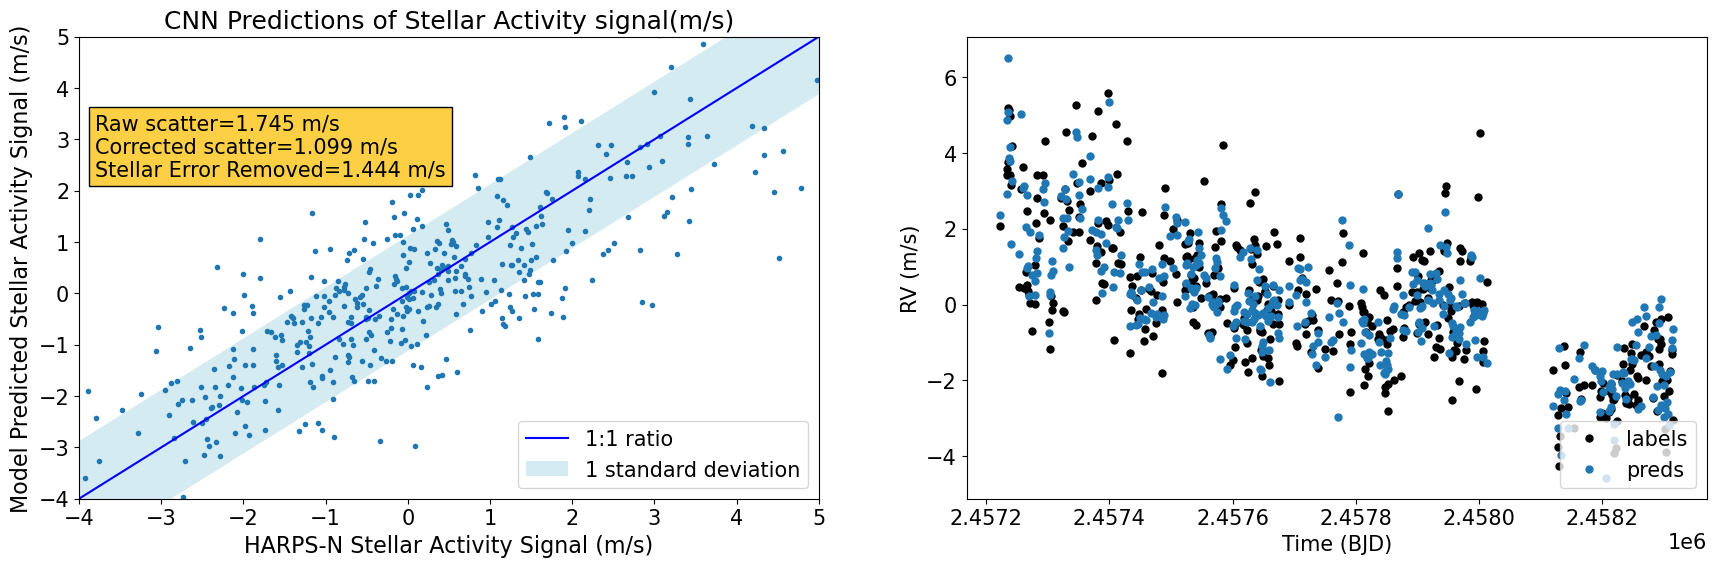

In [13]:

# plot the average results
# Scatter reduction plot
rms_avg_list = []
sd_x = np.std(all_mean_val_labels, ddof=1)
rms_x = np.sqrt(np.mean(np.square(all_mean_val_labels - np.array(all_mean_val_preds))))
#rms_x_list.append(rms_x)
rms_avg_list.append(rms_x)
stel_removed = np.sqrt(np.abs(sd_x**2-rms_x**2))
x_range = np.linspace(-4,5.5, 17)
upper_bound = x_range+rms_x
lower_bound = x_range-rms_x

# plot the scatter reduction plot
fig, ax = plt.subplots(1, 2, figsize=(21, 6))
ax1 = ax[0]
ax1.plot(df_sorted["labels"], df_sorted["preds"], ".")
ax1.plot(x_range,x_range, color="blue", label="1:1 ratio")
#ax.plot(x_range,z[0]*x_range+z[1], color="blue")
rms_fill=rms_x#0.15
ax1.fill_between(x_range, x_range+rms_fill, x_range-rms_fill, facecolor='lightblue',
                alpha=0.5, label="1 standard deviation")
ax1.set_xlim(-4, 5);
ax1.set_ylim(-4, 5);
ax1.set_xlabel("HARPS-N Stellar Activity Signal (m/s)", size =16)
ax1.set_ylabel("Model Predicted Stellar Activity Signal (m/s)", size =16)
ax1.set_title("CNN Predictions of Stellar Activity signal(m/s)") #, %d epochs, weight decay: %.2e, gauss noise: %.2e " %(num_epochs, 
#hparams.weight_decay, hparams.gaussian_noise_scale, size=16)
textstr = '\n'.join((
    r'Raw scatter=%.3f m/s' % (labels_68_percent_by_2, ),
    r'Corrected scatter=%.3f m/s' % (corrected_rvs_68_percent_by_2, ),
    r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
ax1.text(-3.8, 3.5, textstr, size=15,
        ha="left", va="top",
        bbox=dict(facecolor='#fdcf44',edgecolor='k',
                  boxstyle="square",
                  #ec=(1., 0.5, 0.5),
                  #fc=(1., 0.8, 0.8),
                  ))
ax1.legend(loc="lower right")

# plot predictions over time
ax2 = ax[1]
ax2.plot(df_sorted["BJD"], df_sorted["labels"], ".",color='k',
         markersize=10,label="labels")
ax2.plot(df_sorted["BJD"], df_sorted["preds"], ".", markersize=10,
         label="preds")
ax2.set_xlabel("Time (BJD)")
ax2.set_ylabel("RV (m/s)")
ax2.legend(loc="lower right")